In [64]:
import pandas as pd
import seaborn as sns

In [72]:
def readFileAsArr(fileName, source):
    res = []
    file = open('/home/brgverst/benchres/' + fileName, encoding="utf8").read()
    for ind, line in enumerate(file.split('\n')):
        if ind < 100:
            continue
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([source, splitLine[0], splitLine[1], float(splitLine[2])])
    return res

latencies = readFileAsArr('plumber.txt', 'Plumber')
latencies = latencies + readFileAsArr('baseline.txt', 'Baseline')
latencies = latencies + readFileAsArr('dapr.txt', 'Dapr')

In [73]:
df = pd.DataFrame(latencies, columns=['Platform', 'Begin nano', 'End nano', 'latency (ms)'])

In [74]:
df.groupby(["Platform"]).describe()


latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      10000.0  2.406671  2.598142  1.291234  2.050292  2.207116   
Dapr          10000.0  2.675171  2.736297  1.727504  2.274632  2.437731   
Plumber       10000.0  2.930199  2.962947  1.846369  2.495594  2.667276   

                               
               75%        max  
Platform                       
Baseline  2.379767  69.902432  
Dapr      2.642404  70.083678  
Plumber   2.876739  70.250253

In [75]:
df.head()

,Platform,Begin nano,End nano,latency (ms)
0,Plumber,1628670420943280435,1628670420946215520,2.935085
1,Plumber,1628670421044577768,1628670421049273554,4.695786
2,Plumber,1628670421145815086,1628670421148982880,3.167794
3,Plumber,1628670421247018872,1628670421250187034,3.168162
4,Plumber,1628670421348333923,1628670421351351783,3.017860


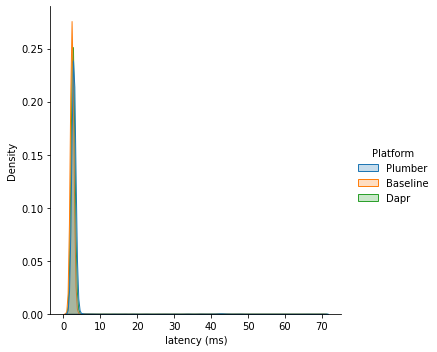

In [76]:
sns.displot(df, x="latency (ms)", hue="Platform", kind="kde", fill=True)

<AxesSubplot:xlabel='latency (ms)', ylabel='Proportion'>

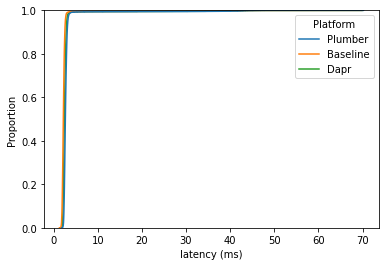

In [55]:
sns.ecdfplot(data=df, x="latency (ms)", hue="Platform")

In [77]:
df.shape

(30000, 4)

In [78]:
# Obvious issue with outliers for visualizations: remove them through IQR method
plat_dfs = []
for plat in df["Platform"].unique():
    print(plat)
    df_plat = df[df["Platform"] == plat]
    q1 = df_plat.quantile(0.25)["latency (ms)"]
    q3 = df_plat.quantile(0.75)["latency (ms)"]
    iqr = q3 - q1
    print(df_plat.shape)
    df_plat = df_plat[~((df["latency (ms)"] < (q1 - 1.5 * iqr)) | (df["latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
    print(df_plat.shape)
    plat_dfs.append(df_plat)

filtered_df = pd.concat(plat_dfs)


Plumber
(10000, 4)
(9783, 4)
Baseline
(10000, 4)
(9818, 4)
Dapr
(10000, 4)
(9797, 4)


<ipython-input-78-ce2028323010>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["latency (ms)"] < (q1 - 1.5 * iqr)) | (df["latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-78-ce2028323010>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["latency (ms)"] < (q1 - 1.5 * iqr)) | (df["latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-78-ce2028323010>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["latency (ms)"] < (q1 - 1.5 * iqr)) | (df["latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)


In [79]:
filtered_df.groupby(["Platform"]).describe()

latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline       9818.0  2.214440  0.232366  1.560981  2.047219  2.201952   
Dapr           9797.0  2.459035  0.255296  1.727504  2.270767  2.430236   
Plumber        9783.0  2.683987  0.261814  1.937981  2.491717  2.658401   

                              
               75%       max  
Platform                      
Baseline  2.371029  2.871656  
Dapr      2.628614  3.193542  
Plumber   2.859193  3.446367

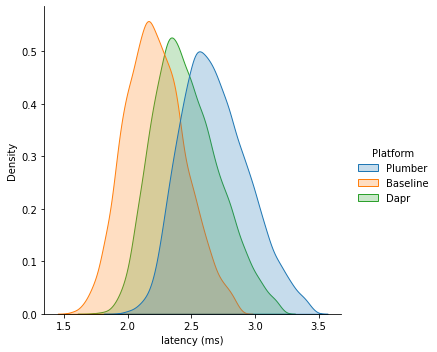

In [80]:
sns.displot(filtered_df, x="latency (ms)", hue="Platform", kind="kde", fill=True)

<AxesSubplot:xlabel='latency (ms)', ylabel='Proportion'>

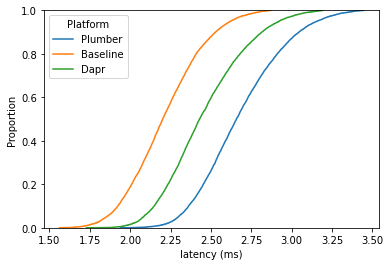

In [81]:
sns.ecdfplot(data=filtered_df, x="latency (ms)", hue="Platform")

In [82]:
# preprocessing for catplot
df_metrics = pd.DataFrame(columns=["Metric", "Platform", "Latency (ms)"])
for plat in df["Platform"].unique():
    plat_df = df[df["Platform"] == plat]
    df_metrics = df_metrics.append({"Metric": "Median", "Platform": plat, "Latency (ms)": plat_df.quantile(0.5)["latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "90th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.9)["latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "99th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.99)["latency (ms)"]}, ignore_index=True) 

In [83]:
df_metrics.head()

,Metric,Platform,Latency (ms)
0,Median,Plumber,2.667276
1,90th Percentile,Plumber,3.082178
2,99th Percentile,Plumber,3.966323
3,Median,Baseline,2.207116
4,90th Percentile,Baseline,2.554532


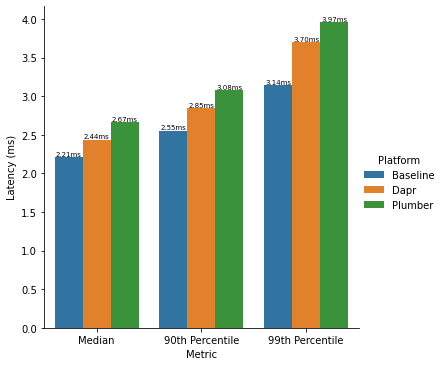

In [84]:
g = sns.catplot(
    data=df_metrics, kind="bar",
    x="Metric", y="Latency (ms)", hue="Platform",
    hue_order=["Baseline", "Dapr", "Plumber"]
)
ax = g.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}ms' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', fontsize='x-small')